In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.datasets import ImageDataset, TupleDataset, LabeledImageDataset
import numpy as np
%matplotlib inline
import scipy.misc
import matplotlib.pyplot as plt

In [3]:
#train, test = chainer.datasets.get_cifar10()

In [4]:
# folder names and their count
root = "/home/place-recognizer-students/flickr-workflow/crawled-data/"
# 0: berlinerdom, 1: brandenburgertor, 2: fernsehturm, 3: funkturm, 4: reichstag, 5: rotesrathaus, 6: siegessaeule, 7: none
classes = [0, 1, 2, 3, 4, 5, 6, 7]
classCounts = {
    "berlinerdom": 5772,
    "brandenburgertor": 3074,
    "fernsehturm": 4150,
    "funkturm": 4997,
    "reichstag": 5795,
    "rotesrathaus": 4765,
    "siegessaeule": 3805,
    "none": 4307
}

trainPairs = []
testPairs = []

for className, count in classCounts.items():
    print("%s: %s elements" % (className, count))
    path = root + className
    pathList = path + "/paths.txt"
    # from https://github.com/chainer/chainer/blob/master/chainer/datasets/image_dataset.py
    with open(pathList) as pairs_file:
            for i, line in enumerate(pairs_file):
                pair = line.strip().split()
                if len(pair) != 2:
                    raise ValueError(
                        'invalid format at line {} in file {}'.format(
                            i, pairs_path))
                if i <= 1800:
                    trainPairs.append((className + "/" + pair[0], int(pair[1])))
                elif i <= 3000:
                    testPairs.append((className + "/" + pair[0], int(pair[1])))
train = LabeledImageDataset(trainPairs, root)
test = LabeledImageDataset(testPairs, root)


none: 4307 elements
berlinerdom: 5772 elements
siegessaeule: 3805 elements
funkturm: 4997 elements
reichstag: 5795 elements
rotesrathaus: 4765 elements
brandenburgertor: 3074 elements
fernsehturm: 4150 elements


In [102]:
print(type(train[0][0][0][0][0]))

<class 'numpy.float32'>


### Resize train images to 32x32

In [23]:
i_width = 32
i_height = 32

res = []
test_train = train
train_count = len(test_train)

# progress bar magic
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=train_count) # instantiate the bar
display(f)

for i, (img, label) in enumerate(test_train):
    f.value += 1
    try:
        new = scipy.misc.imresize(img, (i_height, i_width))
        res.append((new, label))
    except ValueError:
        print("An error occured with element at position %s" % i)


An error occured with element at position 347
An error occured with element at position 1467
An error occured with element at position 1568
An error occured with element at position 2065
An error occured with element at position 2459
An error occured with element at position 2949
An error occured with element at position 4492
An error occured with element at position 4498
An error occured with element at position 4775
An error occured with element at position 4891
An error occured with element at position 5190
An error occured with element at position 5218
An error occured with element at position 5227
An error occured with element at position 6379
An error occured with element at position 7287
An error occured with element at position 7692
An error occured with element at position 8131
An error occured with element at position 9062
An error occured with element at position 9264
An error occured with element at position 9278
An error occured with element at position 9395
An error occur

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


### Resize test images to 32x32

In [24]:
i_width = 32
i_height = 32

res_test = []
test_test = test
test_count = len(test_test)

# progress bar magic
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=test_count) # instantiate the bar
display(f)

for i, (img, label) in enumerate(test_test):
    f.value += 1
    try:
        new = scipy.misc.imresize(img, (i_height, i_width))
        res_test.append((new, label))
    except ValueError:
        print("An error occured with element at position %s" % i)

An error occured with element at position 2094
An error occured with element at position 4398
An error occured with element at position 4603
An error occured with element at position 4604


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# Training set errors (only has 1 dimension instead of 3)
347
1467
1568
2065
2459
2949
4492
4498
4775
4891
5190
5218
5227
6379
7287
7692
8131
9062
9264
9278
9395
9790
11071
11441
12391
13351
13397
13464
13519
13528
13734
13984
14295
# Test set errors
2094
4398
4603
4604

(3, 1600, 1592)
(32, 32, 3)


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


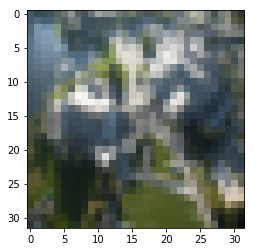

In [15]:
#img = train[347][0][0]
#imgplot = plt.imshow(img.astype('uint8'))
new_img = scipy.misc.imresize(train[6][0], (32, 32))
imgplot2 = plt.imshow(new_img.astype('uint8'))
print(train[0][0].shape)
print(new_img.shape)

In [141]:
# correct type of array, imresize converts it to unit8 and the CNN wants float32
trainset = []

for img, label in res:
    trainset.append((img.astype('float32'), label))

testset = []
for img, label in res_test:
    testset.append((img.astype('float32'), label))
    

In [142]:
class CNN(chainer.Chain):
    def __init__(self, n_out):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 16, 3, 1)
            self.conv2 = L.Convolution2D(16, 32, 3, 2)
            self.conv3 = L.Convolution2D(32, 32, 3, 1)
            self.conv4 = L.Convolution2D(32, 64, 3, 2)
            self.conv5 = L.Convolution2D(64, 64, 3, 1)
            self.conv6 = L.Convolution2D(64, 128, 3, 2)
            self.fc7 = L.Linear(None, 100)
            self.fc8 = L.Linear(100, n_out)
 
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.fc7(h))
        h = self.fc8(h)
        return h

In [143]:
from chainer import optimizers, iterators, training
from chainer.training import extensions
def train_model(model, batch_size=64, epoch=20):
    classifier_model = L.Classifier(model)
 
    # 2. Setup an optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(classifier_model)
 
    # 3. Load the CIFAR-10 dataset
    #train, test = chainer.datasets.get_cifar10()
    train = trainset
    test = testset
 
    # 4. Setup an Iterator
    train_iter = iterators.SerialIterator(train, batch_size)
    test_iter = iterators.SerialIterator(test, batch_size,
                                         repeat=False, shuffle=False)
 
    # 5. Setup an Updater
    updater = training.StandardUpdater(train_iter, optimizer)
    # 6. Setup a trainer (and extensions)
    trainer = training.Trainer(updater, (epoch, 'epoch'))
 
    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, classifier_model))
 
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(1, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'validation/main/loss'],
        x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        x_key='epoch',
        file_name='accuracy.png'))
 
    trainer.extend(extensions.ProgressBar())
 
    # Run the training
    trainer.run()

In [144]:
train_model(CNN(7))

Exception in main training loop: Width in the output should be positive.
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/chainer/training/trainer.py", line 299, in run
    update()
  File "/usr/local/lib/python3.4/dist-packages/chainer/training/updater.py", line 223, in update
    self.update_core()
  File "/usr/local/lib/python3.4/dist-packages/chainer/training/updater.py", line 234, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python3.4/dist-packages/chainer/optimizer.py", line 528, in update
    loss = lossfun(*args, **kwds)
  File "/usr/local/lib/python3.4/dist-packages/chainer/links/model/classifier.py", line 114, in __call__
    self.y = self.predictor(*args, **kwargs)
  File "<ipython-input-142-11be336b0edc>", line 16, in __call__
    h = F.relu(self.conv2(h))
  File "/usr/local/lib/python3.4/dist-packages/chainer/links/connection/convolution_2d.py", line 153, in __call__
    x, self.W, self.b, self.stride, s

AssertionError: Width in the output should be positive.

In [176]:
for i in range(14375):
    if trainset[i][0].shape != (32, 32, 3):
        print(i)